# 2025 Monaco GP Strategy - Monte Carlo Simulation

This simulates race strategies for a backmarker starting near the back of the field for the 2025 Monaco Grand Prix. It compares actual strategy from the race to a early 2-stop strategy suggested on Sky Sports by Bernie Collins. Because Monaco is famously difficult to overtake, the model prioritizes track position an pit windows


### Tuning the Model
- **P_EARLY_SC**: Probability of an early lap 1–2 Safety Car. Increase to favor the Collins strategy, as an early safety car aids her strategy.
- **PIT_LOSS_MEAN/SD**: Average pit delta at Monaco. Reduce when pitting under SC (10s reduction used here).
- **LAP_NOISE_SD**: Per-lap stochasticity.
- **DEGRAD_SD_FACTOR**: Uncertainty in degradation slope; larger means more spread in outcomes.
- **PASS_THRESHOLD**: How hard overtaking is (time advantage per lap needed across the race). Larger means harder to pass.

### Limitations
- Very simplified field model—does not explicitly simulate every car's pit timing, traffic, and blue flags.
- Degradation model is linear and fit from a single car; consider pooling by compound across multiple cars.
- SC detection and effects are simplified.

In [40]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import fastf1
from fastf1 import plotting
from fastf1.core import Laps

# FastF1 cache
cache_dir = os.environ.get('FASTF1_CACHE', str(Path.home() / '.fastf1' / 'cache'))
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)
print('Using FastF1 cache at:', cache_dir)


plotting.setup_mpl(misc_mpl_mods=False)

Using FastF1 cache at: C:\Users\Naya\.fastf1\cache


In [41]:
#  Parameters
YEAR = 2025
EVENT = 'Monaco'  # Monaco GP
SESSION = 'R'     # Race

N_RUNS = 1000             # Monte Carlo iterations
BASELINE_DRIVER = None    # use driver code, here None to auto-pick a backmarker based on grid

# Early Safety Car probability and window
P_EARLY_SC = 0.35         # Probability of a full Safety Car on laps 1-2, set for 35% right now
EARLY_SC_LAPS = [1, 2]

# Pit loss assumptions (Monaco pit lane is relatively short/slow; tune as needed)
PIT_LOSS_MEAN = 19.0      # seconds, stationary + pit lane delta combined
PIT_LOSS_SD = 1.5

# Lap time noise
LAP_NOISE_SD = 0.35       # per-lap random noise, epsilon

# Tire degradation slope multipliers uncertainty (per compound)
DEGRAD_SD_FACTOR = 0.25   # relative noise on fitted degradation slopes

# Overtaking difficulty
PASS_THRESHOLD = 1.2      # seconds per lap faster needed to complete a pass

# Random seed for reproducibility (set to None for different results each run if needed)
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

In [42]:
# session creation, laps, and stints

session = fastf1.get_session(YEAR, EVENT, SESSION)
session.load(weather=True, messages=True)
print(session.event['EventName'], session.event['EventDate'])

laps_all: Laps = session.laps
results = session.results
grid_sorted = results.sort_values('GridPosition', ascending=True)
print(grid_sorted[['Abbreviation', 'DriverNumber', 'TeamName', 'GridPosition', 'Position']].to_string(index=False))

if BASELINE_DRIVER is None:
    # auto-pick a backmarker (last on the grid who started, BEA here)
    back = grid_sorted.dropna(subset=['GridPosition'])
    back = back[back['GridPosition'] > 0]
    BASELINE_DRIVER = back.iloc[-1]['Abbreviation'] if len(back) else grid_sorted.iloc[-1]['Abbreviation']
print('Selected baseline driver:', BASELINE_DRIVER)

# Extract laps for the selected driver
ddlaps = laps_all.pick_driver(BASELINE_DRIVER).copy()

def _is_pitout(df: pd.DataFrame) -> pd.Series:
    if 'PitOutLap' in df.columns:
        return df['PitOutLap'].fillna(False)
    if 'PitOutTime' in df.columns:
        return df['PitOutTime'].notna()
    return pd.Series(False, index=df.index)

def _is_pitin(df: pd.DataFrame) -> pd.Series:
    if 'PitInLap' in df.columns:
        return df['PitInLap'].fillna(False)
    if 'PitInTime' in df.columns:
        return df['PitInTime'].notna()
    return pd.Series(False, index=df.index)

pitout = _is_pitout(dlaps)
pitin  = _is_pitin(dlaps)

dlaps = dlaps[~pitout & ~pitin].copy()

if 'TrackStatus' in dlaps.columns:
    ts = dlaps['TrackStatus'].astype(str)
    dlaps = dlaps[(ts == '1') | (dlaps['TrackStatus'].isna())]

# keep only laps with a time
dlaps = dlaps.dropna(subset=['LapTime'])

print(dlaps[['LapNumber','Compound','LapTime','TyreLife','FreshTyre']].head().to_string(index=False))

# Get stint info per driver
driver_stints = session.laps.pick_driver(BASELINE_DRIVER).copy()

def compute_stints(laps_df):
    # Build simple stints table (compound, start_lap, end_lap)
    rows = []
    if laps_df.empty:
        return pd.DataFrame(columns=['Compound','StartLap','EndLap'])
    current_comp = None
    start = None
    for _, row in laps_df.sort_values('LapNumber').iterrows():
        comp = row.get('Compound')
        lapn = row['LapNumber']
        if comp != current_comp:
            if current_comp is not None:
                rows.append({'Compound': current_comp, 'StartLap': start, 'EndLap': lapn-1})
            current_comp = comp
            start = lapn
    # close last
    rows.append({'Compound': current_comp, 'StartLap': start, 'EndLap': laps_df['LapNumber'].max()})
    return pd.DataFrame(rows)

actual_stints = compute_stints(session.laps.pick_driver(BASELINE_DRIVER))
print(actual_stints)

# Race control messages for SC/VSC
rcm = session.race_control_messages
print(rcm.head().to_string(index=False))

# Show which driver and plans are being simulated
print("Baseline driver:", BASELINE_DRIVER)
print("Actual pit plan:", actual_plan)
print("Collins pit plan:", collins_strategy())

# important output here is the baseline driver being used in the simulation and the corresponding tires for each strategy

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']


Monaco Grand Prix 2025-05-25 00:00:00
Abbreviation DriverNumber        TeamName  GridPosition  Position
         NOR            4         McLaren           1.0       1.0
         LEC           16         Ferrari           2.0       2.0
         PIA           81         McLaren           3.0       3.0
         VER            1 Red Bull Racing           4.0       4.0
         HAD            6    Racing Bulls           5.0       6.0
         ALO           14    Aston Martin           6.0      19.0
         HAM           44         Ferrari           7.0       5.0
         OCO           31    Haas F1 Team           8.0       7.0
         LAW           30    Racing Bulls           9.0       8.0
         ALB           23        Williams          10.0       9.0
         SAI           55        Williams          11.0      10.0
         TSU           22 Red Bull Racing          12.0      17.0
         HUL           27     Kick Sauber          13.0      16.0
         RUS           63        Merce

  Compound       Base     Slope
0     HARD  72.854409  0.499409
1   MEDIUM  78.757234 -0.020572


,Compound,Base,Slope
0,HARD,72.854409,0.499409
1,MEDIUM,78.757234,-0.020572


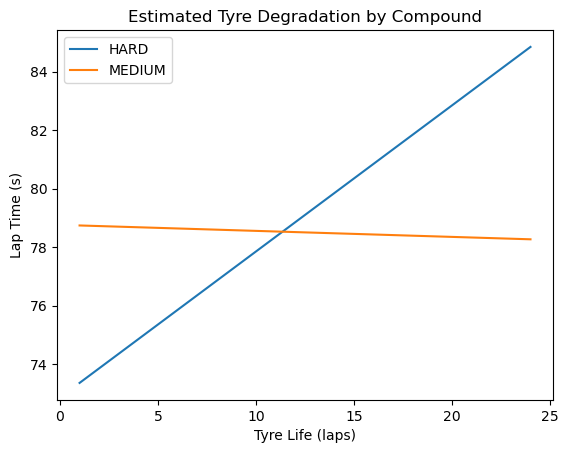

Detected SC laps (rough): [] ...
Race laps: 78
Actual plan (derived): [{'lap': 2, 'compound': 'HARD'}, {'lap': 18, 'compound': 'MEDIUM'}]


In [43]:
# Simulation creation

def to_seconds(td):
    if pd.isna(td):
        return np.nan
    return td.total_seconds()

clean = session.laps.pick_driver(BASELINE_DRIVER).copy()
clean = clean[~_is_pitout(clean) & ~_is_pitin(clean)].copy()
if 'TrackStatus' in clean.columns:
    ts = clean['TrackStatus'].astype(str)
    clean = clean[(ts == '1') | (clean['TrackStatus'].isna())]
clean = clean.dropna(subset=['LapTime'])
clean['LapTimeSec'] = clean['LapTime'].dt.total_seconds()


def fit_degradation_by_compound(df):
    # Regress LapTimeSec ~ TyreLife (linear) per compound to get base + slope
    out = []
    for comp, g in df.groupby('Compound'):
        g2 = g.dropna(subset=['TyreLife','LapTimeSec'])
        if len(g2) < 5:
            continue
        # simple OLS
        x = g2['TyreLife'].values
        y = g2['LapTimeSec'].values
        A = np.vstack([np.ones_like(x), x]).T
        coef, *_ = np.linalg.lstsq(A, y, rcond=None)
        base, slope = coef[0], coef[1]
        out.append({'Compound': comp, 'Base': base, 'Slope': slope})
    return pd.DataFrame(out)

deg_table = fit_degradation_by_compound(clean)
if deg_table.empty:
    # Fallback reasonable assumptions if data sparse, not used
    deg_table = pd.DataFrame([
        {'Compound': 'SOFT', 'Base': clean['LapTimeSec'].median(),     'Slope': 0.05},
        {'Compound': 'MEDIUM','Base': clean['LapTimeSec'].median()+0.3,'Slope': 0.04},
        {'Compound': 'HARD',  'Base': clean['LapTimeSec'].median()+0.6,'Slope': 0.03},
    ])

print(deg_table)
display(deg_table)
# Visualize degradation model by compound
plt.figure()
for comp in deg_table['Compound']:
    base, slope = deg_table.loc[deg_table['Compound'] == comp, ['Base', 'Slope']].values[0]
    tyre_age = np.arange(1, 25)
    plt.plot(tyre_age, base + slope * tyre_age, label=comp)
plt.xlabel("Tyre Life (laps)")
plt.ylabel("Lap Time (s)")
plt.title("Estimated Tyre Degradation by Compound")
plt.legend()
plt.show()


def detect_actual_sc_laps(rcm_df):
    # Very rough detection of SC windows from Race Control messages
    # Look for 'SAFETY CAR DEPLOYED' ... 'SAFETY CAR IN THIS LAP'
    sc_laps = set()
    if rcm_df is None or rcm_df.empty:
        return sc_laps
    deployed = None
    for _, row in rcm_df.iterrows():
        msg = str(row.get('Message', '')).upper()
        lap = row.get('LapNumber')
        if 'SAFETY CAR DEPLOYED' in msg and lap is not None:
            deployed = lap
        if deployed is not None and lap is not None:
            sc_laps.add(lap)
        if 'SAFETY CAR IN THIS LAP' in msg:
            deployed = None
    return sc_laps

actual_sc_laps = detect_actual_sc_laps(rcm)
print('Detected SC laps (rough):', sorted(list(actual_sc_laps))[:20], '...')

RACE_LAPS = int(session.total_laps)
print('Race laps:', RACE_LAPS)

def draw_pit_loss():
    return max(12.0, rng.normal(PIT_LOSS_MEAN, PIT_LOSS_SD))

def sample_degradation(compound):
    row = deg_table[deg_table['Compound'].str.upper() == str(compound).upper()]
    if row.empty:
        # Fallback to medium-like
        base = deg_table['Base'].median()
        slope = deg_table['Slope'].median()
    else:
        base = row['Base'].values[0]
        slope = row['Slope'].values[0]
    # Add uncertainty to slope
    slope = max(0.0, slope * (1 + rng.normal(0.0, DEGRAD_SD_FACTOR)))
    return base, slope

def lap_time_for(compound, tyre_age):
    base, slope = sample_degradation(compound)
    lt = base + slope * tyre_age + rng.normal(0.0, LAP_NOISE_SD)
    return lt

def collins_strategy(starter_compound='MEDIUM', early_sc_hard='HARD'):
    # If an early SC (lap 1-2), pit lap 1 to SOFT, pit lap 2 to HARD, then to the end
    # Encode the nominal plan as those two early stops
    plan = []
    plan.append({'lap': 1, 'compound': 'SOFT'})
    plan.append({'lap': 2, 'compound': early_sc_hard})
    return plan

def actual_strategy_from_stints(stints_df):
    # Convert stints table into pit plan: at the first lap of each new compound (except lap 1), we pit
    plan = []
    for _, row in stints_df.iterrows():
        if row['StartLap'] > 1:
            plan.append({'lap': int(row['StartLap']), 'compound': str(row['Compound']).upper()})
    return plan

actual_plan = actual_strategy_from_stints(actual_stints)
print('Actual plan (derived):', actual_plan)

# simulation

def simulate_race(pit_plan, start_compound='MEDIUM', early_sc_prob=P_EARLY_SC, enforce_early_sc=True):
    # Simple scalar model for a single car's race time; returns race time and lap-by-lap times
    # Optionally inject an early Safety Car with probability early_sc_prob across EARLY_SC_LAPS
    # We treat SC laps as slower, and pitting under SC removes ~10s from pit loss
    sc_laps = set()
    if enforce_early_sc and rng.random() < early_sc_prob:
        sc_laps.update(EARLY_SC_LAPS)

    total_time = 0.0
    lap_times = []
    tyre_comp = start_compound
    tyre_age = 0
    pit_plan_idx = 0
    pit_plan = sorted(pit_plan, key=lambda x: x['lap'])

    for lap in range(1, RACE_LAPS+1):
        # Check if we pit at the START of this lap
        if pit_plan_idx < len(pit_plan) and pit_plan[pit_plan_idx]['lap'] == lap:
            # Pit loss reduced if under SC
            pl = draw_pit_loss()
            if lap in sc_laps:
                pl = max(6.0, pl - 10.0)
            total_time += pl
            tyre_comp = pit_plan[pit_plan_idx]['compound']
            tyre_age = 0
            pit_plan_idx += 1

        # Compute laptime
        tyre_age += 1
        lt = lap_time_for(tyre_comp, tyre_age)
        if lap in sc_laps:
            lt += 12.0  # SC laps are slower for everyone; tune if needed
        total_time += lt
        lap_times.append(lt)

    return total_time, np.array(lap_times)

def simulate_field_positions(my_total_time, my_laps, grid_pos, others_summary):
    # Very rough track position model: compare total race times with small on-track pass adjustment.
    # others_summary: list of dicts with 'driver','grid','time' (baseline from actual results)
    # We assume overtakes only happen if you're sufficiently faster on average than the car ahead.
    me = {'driver': 'ME', 'grid': grid_pos, 'time': my_total_time}
    field = others_summary + [me]
    field_sorted = sorted(field, key=lambda x: x['time'])

    # Assign provisional finish positions by time
    for i, d in enumerate(field_sorted, start=1):
        d['provisional_pos'] = i

    # Enforce limited passing at Monaco: if someone starts ahead and is not much slower, keep track position
    field_by_grid = sorted(field, key=lambda x: x['grid'])
    # crude pass rule: if trailing car wasn't faster by PASS_THRESHOLD on average, they can't pass the car ahead
    # Just nudge times to preserve car order where passes are unlikely
    for i in range(1, len(field_by_grid)):
        ahead = field_by_grid[i-1]
        me2 = field_by_grid[i]
        if me2['time'] < ahead['time'] and (ahead['time'] - me2['time']) < PASS_THRESHOLD * RACE_LAPS:
            me2['time'] = ahead['time'] + 0.001  # prevent pass here

    final = sorted(field_by_grid, key=lambda x: x['time'])
    for i, d in enumerate(final, start=1):
        d['final_pos'] = i
    return final

# important outputs here are the compounds corresponding base and slope, as well as the visualization of this data, and if there is a safety car (there is not)

In [44]:
# monte carlo runs and summary
others = []
idx = grid_sorted.set_index('Abbreviation')
my_grid = int(idx.loc[BASELINE_DRIVER, 'GridPosition'])
my_final = int(idx.loc[BASELINE_DRIVER, 'Position'])

for _, row in grid_sorted.iterrows():
    abv = row['Abbreviation']
    gridp = row['GridPosition']
    if pd.isna(gridp) or int(gridp) <= 0:
        continue

    laps_d = session.laps.pick_driver(abv).copy()

    # total race time ~ sum of lap times + pit deltas
    ll = laps_d.dropna(subset=['LapTime'])
    # Ensure timedelta -> seconds
    total = ll['LapTime'].dt.total_seconds().sum()

    # Count stops via PitInTime (or PitInLap if it exists)
    stops = int(_is_pitin(laps_d).sum())

    total += stops * PIT_LOSS_MEAN

    if abv != BASELINE_DRIVER:
        others.append({'driver': abv, 'grid': int(gridp), 'time': total})

print('Others in field:', len(others))

# monte carlo runs
def run_mc(plan_builder, label, start_compound='MEDIUM', enforce_early_sc=True):
    results = []
    for i in range(N_RUNS):
        pit_plan = plan_builder()
        ttot, lapsim = simulate_race(pit_plan, start_compound=start_compound, enforce_early_sc=enforce_early_sc)
        final = simulate_field_positions(ttot, lapsim, my_grid, others.copy())
        my_fin = [d for d in final if d['driver']=='ME'][0]['final_pos']
        results.append({'iter': i, 'total_time': ttot, 'finish_pos': my_fin})
    df = pd.DataFrame(results)
    df['label'] = label
    return df

mc_actual = run_mc(lambda: actual_plan,
                   'Actual-like',
                   start_compound=str(actual_stints.iloc[0]['Compound']).upper() if not actual_stints.empty else 'MEDIUM',
                   enforce_early_sc=False)

mc_collins = run_mc(lambda: collins_strategy(),
                    'Collins-early-2-stop',
                    start_compound='MEDIUM',
                    enforce_early_sc=True)

mc_all = pd.concat([mc_actual, mc_collins], ignore_index=True)
print(mc_all.groupby('label')[['total_time','finish_pos']].agg(['mean','std','median']))

print(f"Simulation setup:")
print(f"  Early Safety Car probability: {P_EARLY_SC*100:.0f}%")
print(f"  Pit loss mean: {PIT_LOSS_MEAN}s ± {PIT_LOSS_SD}s")
print(f"  Lap noise (SD): {LAP_NOISE_SD}")
print(f"  Overtake threshold: {PASS_THRESHOLD} s/lap")
print(f"  Number of Monte Carlo runs: {N_RUNS}")

# important outputs here are the table to compare strategy times and finishing position, as well as preview the simulation setup

Others in field: 19
                       total_time                         finish_pos  \
                             mean        std       median       mean   
label                                                                  
Actual-like           6154.385588   6.206794  6154.274756     19.046   
Collins-early-2-stop  7225.981015  48.713364  7224.639409     20.000   

                                       
                           std median  
label                                  
Actual-like           0.929919   19.0  
Collins-early-2-stop  0.000000   20.0  
Simulation setup:
  Early Safety Car probability: 35%
  Pit loss mean: 19.0s ± 1.5s
  Lap noise (SD): 0.35
  Overtake threshold: 1.2 s/lap
  Number of Monte Carlo runs: 1000


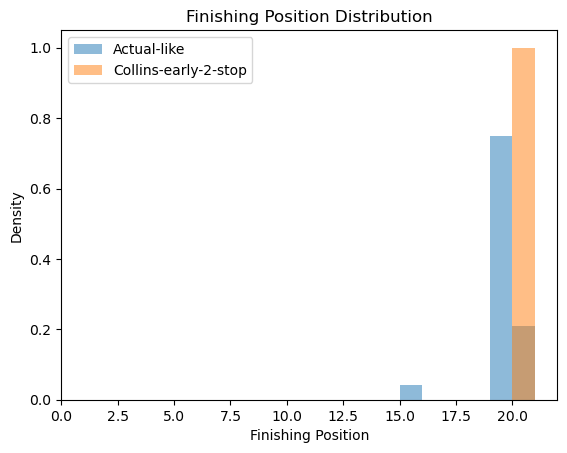

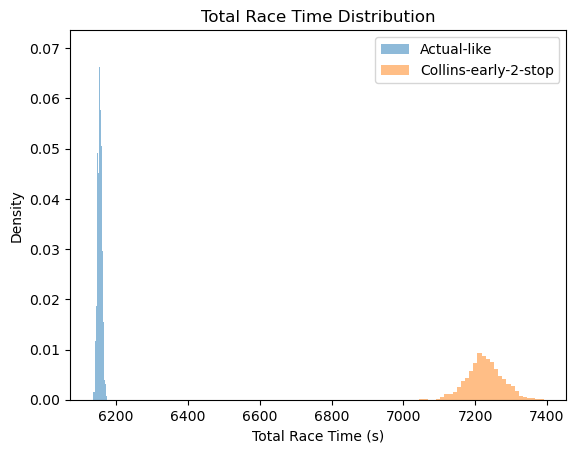

                      avg_finish  p_top10  p_better_than_grid     avg_time
label                                                                     
Actual-like               19.046      0.0                0.79  6154.385588
Collins-early-2-stop      20.000      0.0                0.00  7225.981015


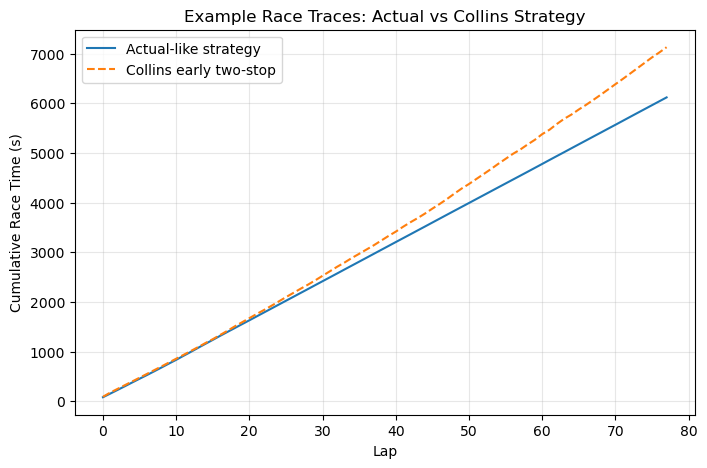

In [45]:
# visualizations

plt.figure()
for label, g in mc_all.groupby('label'):
    plt.hist(g['finish_pos'], bins=range(1, 22), alpha=0.5, label=label, density=True)
plt.xlabel('Finishing Position')
plt.ylabel('Density')
plt.title('Finishing Position Distribution')
plt.legend()
plt.show()

plt.figure()
for label, g in mc_all.groupby('label'):
    plt.hist(g['total_time'], bins=30, alpha=0.5, label=label, density=True)
plt.xlabel('Total Race Time (s)')
plt.ylabel('Density')
plt.title('Total Race Time Distribution')
plt.legend()
plt.show()

summary = (mc_all
           .groupby('label')
           .agg(avg_finish=('finish_pos','mean'),
                p_top10=('finish_pos', lambda s: (s<=10).mean()),
                p_better_than_grid=('finish_pos', lambda s: (s<my_grid).mean()),
                avg_time=('total_time','mean'))
          )
print(summary)

# race trace plot
plt.figure(figsize=(8,5))

_, laps_actual = simulate_race(actual_plan,
                               start_compound=str(actual_stints.iloc[0]['Compound']).upper()
                               if not actual_stints.empty else 'MEDIUM',
                               enforce_early_sc=False)

_, laps_collins = simulate_race(collins_strategy(),
                                start_compound='MEDIUM',
                                enforce_early_sc=True)

cum_actual = np.cumsum(laps_actual)
cum_collins = np.cumsum(laps_collins)

plt.plot(cum_actual, label='Actual-like strategy', color='tab:blue')
plt.plot(cum_collins, label='Collins early two-stop', color='tab:orange', linestyle='--')

plt.xlabel('Lap')
plt.ylabel('Cumulative Race Time (s)')
plt.title('Example Race Traces: Actual vs Collins Strategy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# important outputs here are the visualizations for the finishing position distribution, and total time distribution.
# I have also plotted the race trace for the two strategies to visually show the difference